In [2]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379496 sha256=dd033cf54996265661a02c06d8da7be3a8cb25f5d80137450b38a122a8f14d4d
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


Episode: 1/15  Reward: -76.88  Epsilon: 0.9416
Episode: 2/15  Reward: -224.93  Epsilon: 0.5264
Episode: 3/15  Reward: -258.36  Epsilon: 0.3157
Episode: 4/15  Reward: -266.26  Epsilon: 0.1581
Episode: 5/15  Reward: -219.84  Epsilon: 0.0845
Episode: 6/15  Reward: -215.40  Epsilon: 0.0350
Episode: 7/15  Reward: -43.12  Epsilon: 0.0135
Episode: 8/15  Reward: -85.38  Epsilon: 0.0100
Episode: 9/15  Reward: -112.20  Epsilon: 0.0100
Episode: 10/15  Reward: -59.28  Epsilon: 0.0100
Episode: 11/15  Reward: -104.22  Epsilon: 0.0100
Episode: 12/15  Reward: -118.74  Epsilon: 0.0100
Episode: 13/15  Reward: -60.08  Epsilon: 0.0100
Episode: 14/15  Reward: -181.62  Epsilon: 0.0100
Episode: 15/15  Reward: -91.53  Epsilon: 0.0100


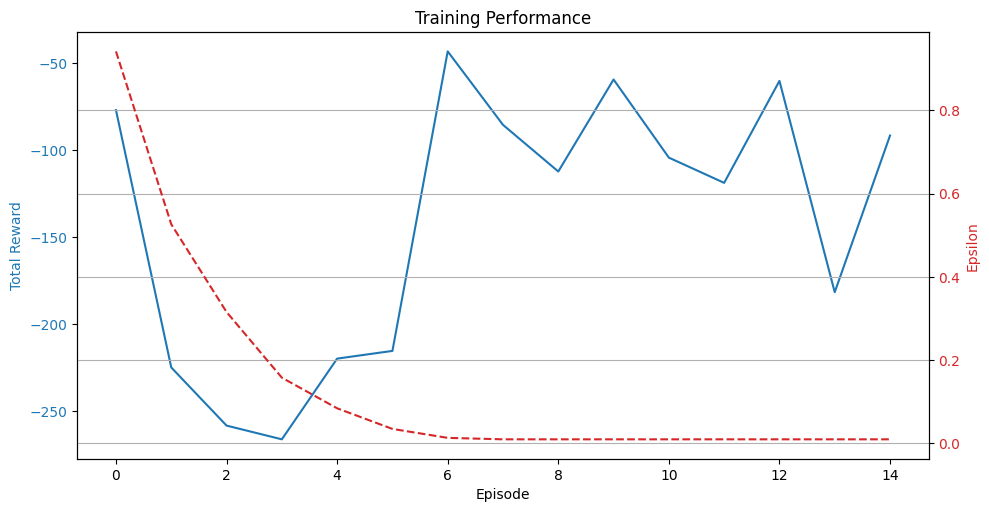

Evaluation Episode: 1  Total Reward: -242.83
Evaluation Episode: 2  Total Reward: -142.10
Evaluation Episode: 3  Total Reward: -103.02
Evaluation Episode: 4  Total Reward: -68.14
Evaluation Episode: 5  Total Reward: -135.16
Evaluation Episode: 6  Total Reward: -100.45
Evaluation Episode: 7  Total Reward: -197.60
Evaluation Episode: 8  Total Reward: -88.40
Evaluation Episode: 9  Total Reward: -77.78
Evaluation Episode: 10  Total Reward: -133.75
Evaluation Episode: 11  Total Reward: -137.41
Evaluation Episode: 12  Total Reward: -67.18
Evaluation Episode: 13  Total Reward: -149.32
Evaluation Episode: 14  Total Reward: -177.16
Evaluation Episode: 15  Total Reward: -96.05


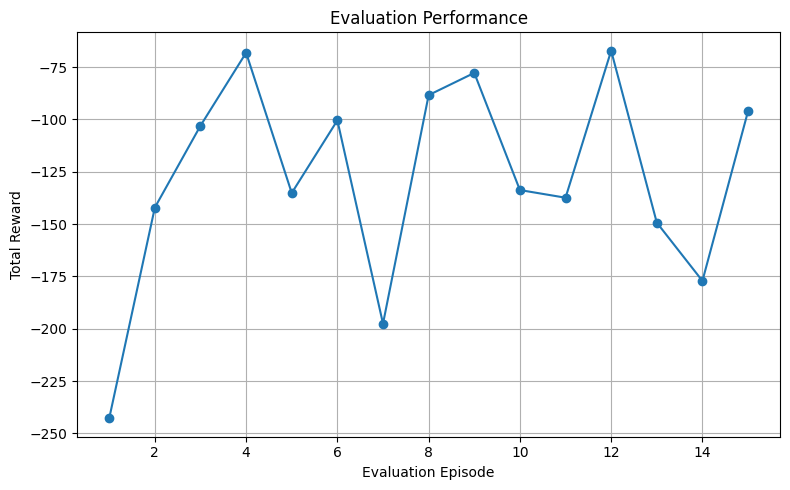

In [6]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import argparse
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = args.gamma
        self.epsilon = args.epsilon_start
        self.epsilon_min = args.epsilon_min
        self.epsilon_decay = args.epsilon_decay
        self.batch_size = args.batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=args.lr)
        self.buffer = ReplayBuffer(args.buffer_capacity)
        self.update_target_steps = args.update_target_steps
        self.step_count = 0
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return q_values.argmax().item()
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.step_count += 1
        if self.step_count % self.update_target_steps == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def plot_training_results(rewards, epsilons):
    episodes = np.arange(len(rewards))
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color='tab:blue')
    ax1.plot(episodes, rewards, color='tab:blue', label="Total Reward")
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Epsilon', color='tab:red')
    ax2.plot(episodes, epsilons, color='tab:red', linestyle='--', label="Epsilon")
    ax2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    plt.title("Training Performance")
    plt.grid(True)
    plt.show()

def plot_evaluation_results(evaluation_rewards):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(evaluation_rewards) + 1), evaluation_rewards, marker='o')
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Total Reward")
    plt.title("Evaluation Performance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def train(env_name, args):
    env = gym.make(env_name)
    state, _ = env.reset()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DQNAgent(state_dim, action_dim, args)
    rewards_history = []
    epsilons_history = []
    for episode in range(args.num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.buffer.push(state, action, reward, next_state, done or truncated)
            state = next_state
            total_reward += reward
            agent.update()
            if done or truncated:
                break
        rewards_history.append(total_reward)
        epsilons_history.append(agent.epsilon)
        print(f"Episode: {episode+1}/{args.num_episodes}  Reward: {total_reward:.2f}  Epsilon: {agent.epsilon:.4f}")
    env.close()
    torch.save(agent.policy_net.state_dict(), f"dqn_{env_name}.pth")
    plot_training_results(rewards_history, epsilons_history)
    return rewards_history, epsilons_history

def evaluate_agent(env_name, model_path, num_episodes=5):
    env = gym.make(env_name)
    state, _ = env.reset()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    args = argparse.Namespace(lr=0.001, gamma=0.99, epsilon_start=0.0, epsilon_min=0.0, epsilon_decay=1.0, batch_size=64, buffer_capacity=10000, update_target_steps=100)
    agent = DQNAgent(state_dim, action_dim, args)
    agent.policy_net.load_state_dict(torch.load(model_path, map_location=agent.device))
    agent.policy_net.eval()
    evaluation_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                q_values = agent.policy_net(state_tensor)
            action = q_values.argmax().item()
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                print(f"Evaluation Episode: {episode+1}  Total Reward: {total_reward:.2f}")
                evaluation_rewards.append(total_reward)
                break
    env.close()
    return evaluation_rewards

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--env", type=str, default="LunarLander-v3")
    parser.add_argument("--num_episodes", type=int, default=15)
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--epsilon_start", type=float, default=1.0)
    parser.add_argument("--epsilon_min", type=float, default=0.01)
    parser.add_argument("--epsilon_decay", type=float, default=0.995)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--buffer_capacity", type=int, default=10000)
    parser.add_argument("--update_target_steps", type=int, default=100)
    parser.add_argument("--test", action="store_true")
    parser.add_argument("--test_episodes", type=int, default=5)
    args, _ = parser.parse_known_args()

    if args.test:
        evaluation_rewards = evaluate_agent(args.env, f"dqn_{args.env}.pth", args.test_episodes)
        plot_evaluation_results(evaluation_rewards)
    else:
        training_rewards, epsilons = train(args.env, args)
        evaluation_rewards = evaluate_agent(args.env, f"dqn_{args.env}.pth", num_episodes=15)
        plot_evaluation_results(evaluation_rewards)

Starting training on CartPole-v1
[CartPole-v1] Episode: 1/100  Reward: 16.00  Epsilon: 1.0000
[CartPole-v1] Episode: 2/100  Reward: 23.00  Epsilon: 1.0000
[CartPole-v1] Episode: 3/100  Reward: 17.00  Epsilon: 1.0000
[CartPole-v1] Episode: 4/100  Reward: 22.00  Epsilon: 0.9276
[CartPole-v1] Episode: 5/100  Reward: 16.00  Epsilon: 0.8561
[CartPole-v1] Episode: 6/100  Reward: 35.00  Epsilon: 0.7183
[CartPole-v1] Episode: 7/100  Reward: 9.00  Epsilon: 0.6866
[CartPole-v1] Episode: 8/100  Reward: 36.00  Epsilon: 0.5733
[CartPole-v1] Episode: 9/100  Reward: 17.00  Epsilon: 0.5264
[CartPole-v1] Episode: 10/100  Reward: 11.00  Epsilon: 0.4982
[CartPole-v1] Episode: 11/100  Reward: 18.00  Epsilon: 0.4552
[CartPole-v1] Episode: 12/100  Reward: 12.00  Epsilon: 0.4286
[CartPole-v1] Episode: 13/100  Reward: 70.00  Epsilon: 0.3018
[CartPole-v1] Episode: 14/100  Reward: 143.00  Epsilon: 0.1474
[CartPole-v1] Episode: 15/100  Reward: 273.00  Epsilon: 0.0375
[CartPole-v1] Episode: 16/100  Reward: 223.00

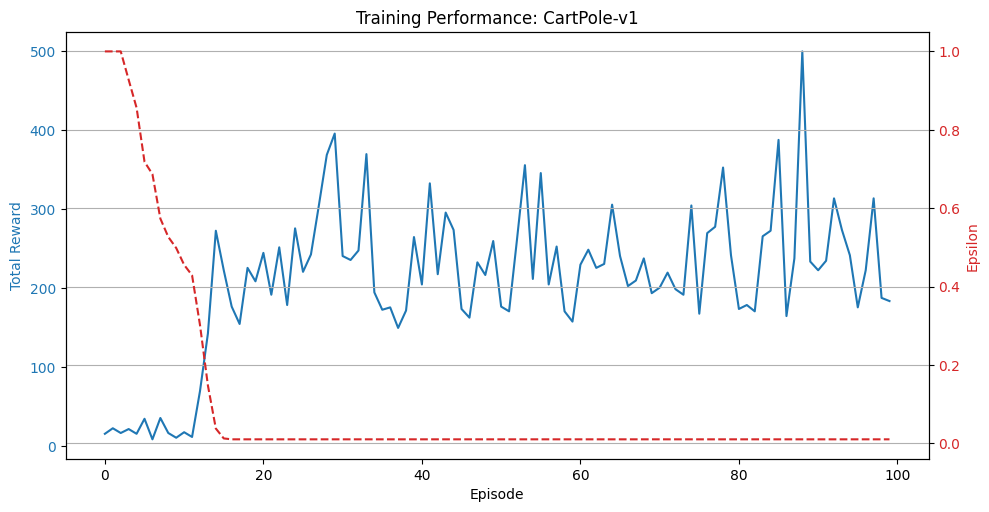

[CartPole-v1] Eval Episode: 1  Total Reward: 189.00
[CartPole-v1] Eval Episode: 2  Total Reward: 196.00
[CartPole-v1] Eval Episode: 3  Total Reward: 187.00
[CartPole-v1] Eval Episode: 4  Total Reward: 197.00
[CartPole-v1] Eval Episode: 5  Total Reward: 189.00


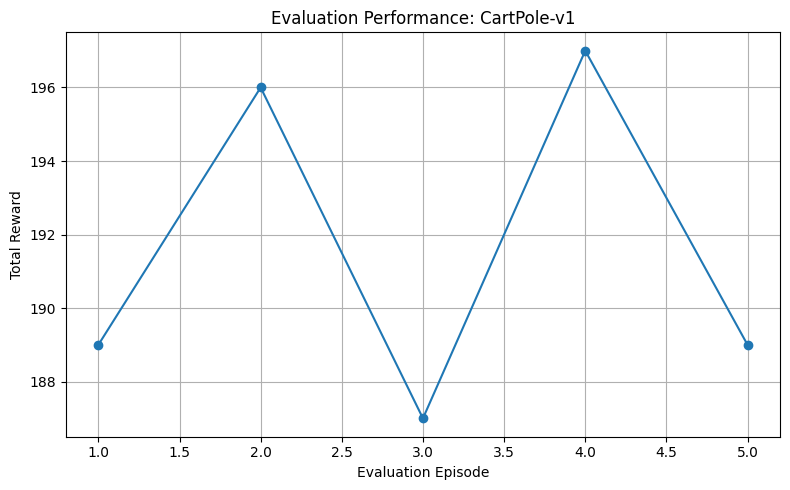

Starting training on LunarLander-v3
[LunarLander-v3] Episode: 1/100  Reward: -165.83  Epsilon: 0.7477
[LunarLander-v3] Episode: 2/100  Reward: -149.78  Epsilon: 0.5398
[LunarLander-v3] Episode: 3/100  Reward: -174.03  Epsilon: 0.3543
[LunarLander-v3] Episode: 4/100  Reward: -195.25  Epsilon: 0.1961
[LunarLander-v3] Episode: 5/100  Reward: -48.95  Epsilon: 0.1206
[LunarLander-v3] Episode: 6/100  Reward: -239.45  Epsilon: 0.0776
[LunarLander-v3] Episode: 7/100  Reward: -266.87  Epsilon: 0.0246
[LunarLander-v3] Episode: 8/100  Reward: 27.14  Epsilon: 0.0101
[LunarLander-v3] Episode: 9/100  Reward: -97.63  Epsilon: 0.0100
[LunarLander-v3] Episode: 10/100  Reward: -243.06  Epsilon: 0.0100
[LunarLander-v3] Episode: 11/100  Reward: -75.77  Epsilon: 0.0100
[LunarLander-v3] Episode: 12/100  Reward: -28.86  Epsilon: 0.0100
[LunarLander-v3] Episode: 13/100  Reward: -112.70  Epsilon: 0.0100
[LunarLander-v3] Episode: 14/100  Reward: -234.93  Epsilon: 0.0100
[LunarLander-v3] Episode: 15/100  Reward:

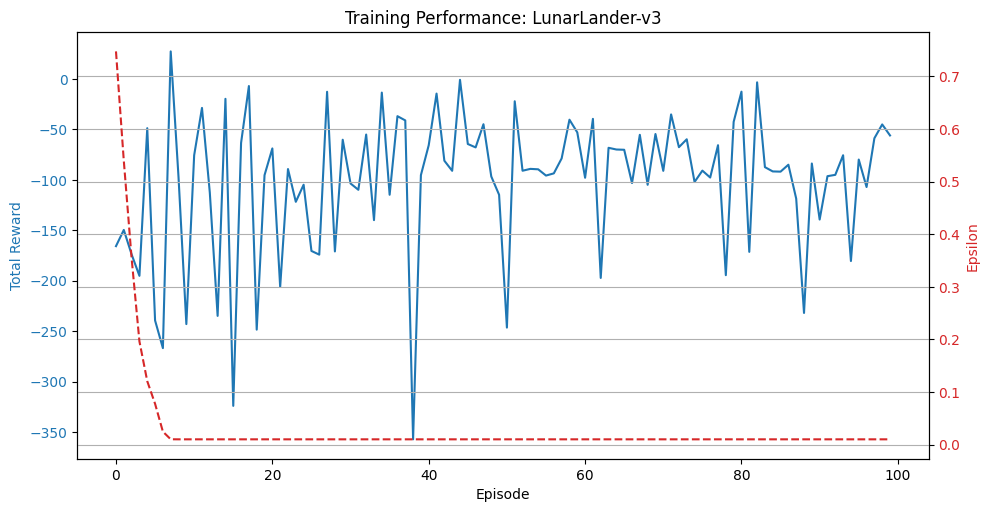

[LunarLander-v3] Eval Episode: 1  Total Reward: -0.87
[LunarLander-v3] Eval Episode: 2  Total Reward: -70.94
[LunarLander-v3] Eval Episode: 3  Total Reward: -85.62
[LunarLander-v3] Eval Episode: 4  Total Reward: -52.98
[LunarLander-v3] Eval Episode: 5  Total Reward: -58.41


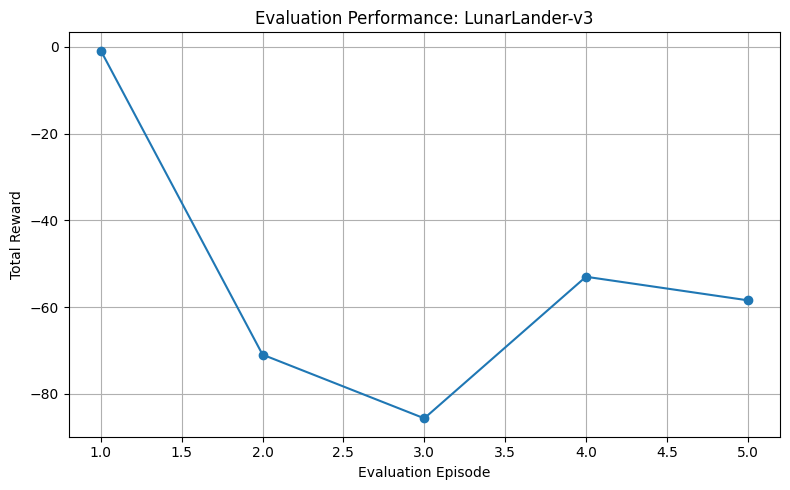

In [7]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import argparse
import matplotlib.pyplot as plt

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = args.gamma
        self.epsilon = args.epsilon_start
        self.epsilon_min = args.epsilon_min
        self.epsilon_decay = args.epsilon_decay
        self.batch_size = args.batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=args.lr)
        self.buffer = ReplayBuffer(args.buffer_capacity)
        self.update_target_steps = args.update_target_steps
        self.step_count = 0
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return q_values.argmax().item()
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.step_count += 1
        if self.step_count % self.update_target_steps == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def plot_training_results(rewards, epsilons, env_name):
    episodes = np.arange(len(rewards))
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color='tab:blue')
    ax1.plot(episodes, rewards, color='tab:blue', label="Total Reward")
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Epsilon', color='tab:red')
    ax2.plot(episodes, epsilons, color='tab:red', linestyle='--', label="Epsilon")
    ax2.tick_params(axis='y', labelcolor='tab:red')
    fig.tight_layout()
    plt.title(f"Training Performance: {env_name}")
    plt.grid(True)
    plt.show()

def plot_evaluation_results(eval_rewards, env_name):
    episodes = np.arange(1, len(eval_rewards) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(episodes, eval_rewards, marker='o')
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Evaluation Performance: {env_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_agent(env_name, model_path, num_episodes=5):
    env = gym.make(env_name)
    state, _ = env.reset()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    args = argparse.Namespace(lr=0.001, gamma=0.99, epsilon_start=0.0, epsilon_min=0.0,
                              epsilon_decay=1.0, batch_size=64, buffer_capacity=10000, update_target_steps=100)
    agent = DQNAgent(state_dim, action_dim, args)
    agent.policy_net.load_state_dict(torch.load(model_path, map_location=agent.device))
    agent.policy_net.eval()
    eval_rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                q_values = agent.policy_net(state_tensor)
            action = q_values.argmax().item()
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state
            if done or truncated:
                print(f"[{env_name}] Eval Episode: {episode+1}  Total Reward: {total_reward:.2f}")
                break
        eval_rewards.append(total_reward)
    env.close()
    return eval_rewards

def train(env_name, args):
    print(f"Starting training on {env_name}")
    env = gym.make(env_name)
    state, _ = env.reset()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DQNAgent(state_dim, action_dim, args)
    rewards_history = []
    epsilons_history = []
    for episode in range(args.num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.buffer.push(state, action, reward, next_state, done or truncated)
            state = next_state
            total_reward += reward
            agent.update()
            if done or truncated:
                break
        rewards_history.append(total_reward)
        epsilons_history.append(agent.epsilon)
        print(f"[{env_name}] Episode: {episode+1}/{args.num_episodes}  Reward: {total_reward:.2f}  Epsilon: {agent.epsilon:.4f}")
    env.close()
    torch.save(agent.policy_net.state_dict(), f"dqn_{env_name}.pth")
    plot_training_results(rewards_history, epsilons_history, env_name)
    return rewards_history, epsilons_history

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--env", type=str, default="both", help='Environment name: "CartPole-v1", "LunarLander-v3", or "both"')
    parser.add_argument("--num_episodes", type=int, default=100)
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--epsilon_start", type=float, default=1.0)
    parser.add_argument("--epsilon_min", type=float, default=0.01)
    parser.add_argument("--epsilon_decay", type=float, default=0.995)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--buffer_capacity", type=int, default=10000)
    parser.add_argument("--update_target_steps", type=int, default=100)
    parser.add_argument("--test", action="store_true")
    parser.add_argument("--test_episodes", type=int, default=5)
    args, _ = parser.parse_known_args()

    envs = ["CartPole-v1", "LunarLander-v3"] if args.env.lower() == "both" else [args.env]

    for env_name in envs:
        if args.test:
            eval_rewards = evaluate_agent(env_name, f"dqn_{env_name}.pth", args.test_episodes)
            plot_evaluation_results(eval_rewards, env_name)
        else:
            train_rewards, epsilons = train(env_name, args)
            eval_rewards = evaluate_agent(env_name, f"dqn_{env_name}.pth", args.test_episodes)
            plot_evaluation_results(eval_rewards, env_name)